<a href="https://colab.research.google.com/github/Artmalik92/Congruence-Test-For-Students/blob/main/geometry_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Геометрический тест в Python

В системах геодезического мониторинга одним из методов обнаружения деформаций является построение ГНСС сетей и анализ движений в них при помощи вычисления невязок в замкнутых фигурах. Данный принцип может быть реализован в виде программы геометрического теста на Python.

Геометрический тест стабильности позволяет выявлять аномальные движения в замкнутой геодезической сети путем вычисления разностей параметров этой сети (внутренних углов, длин базовых линий или координат) на начальную и N-ую эпоху. Если сумма разностей между параметрами статистически не значима, то эти две фигуры конгруэнтны, т. е. аномальных движений нет.

Например, существует треугольник ABC. Нулевая гипотеза геометрического теста заключается в том, что сумма разностей координат точек A, B, C между двумя эпохами должна быть равна нулю. В этом случае треугольник считается стабильным.

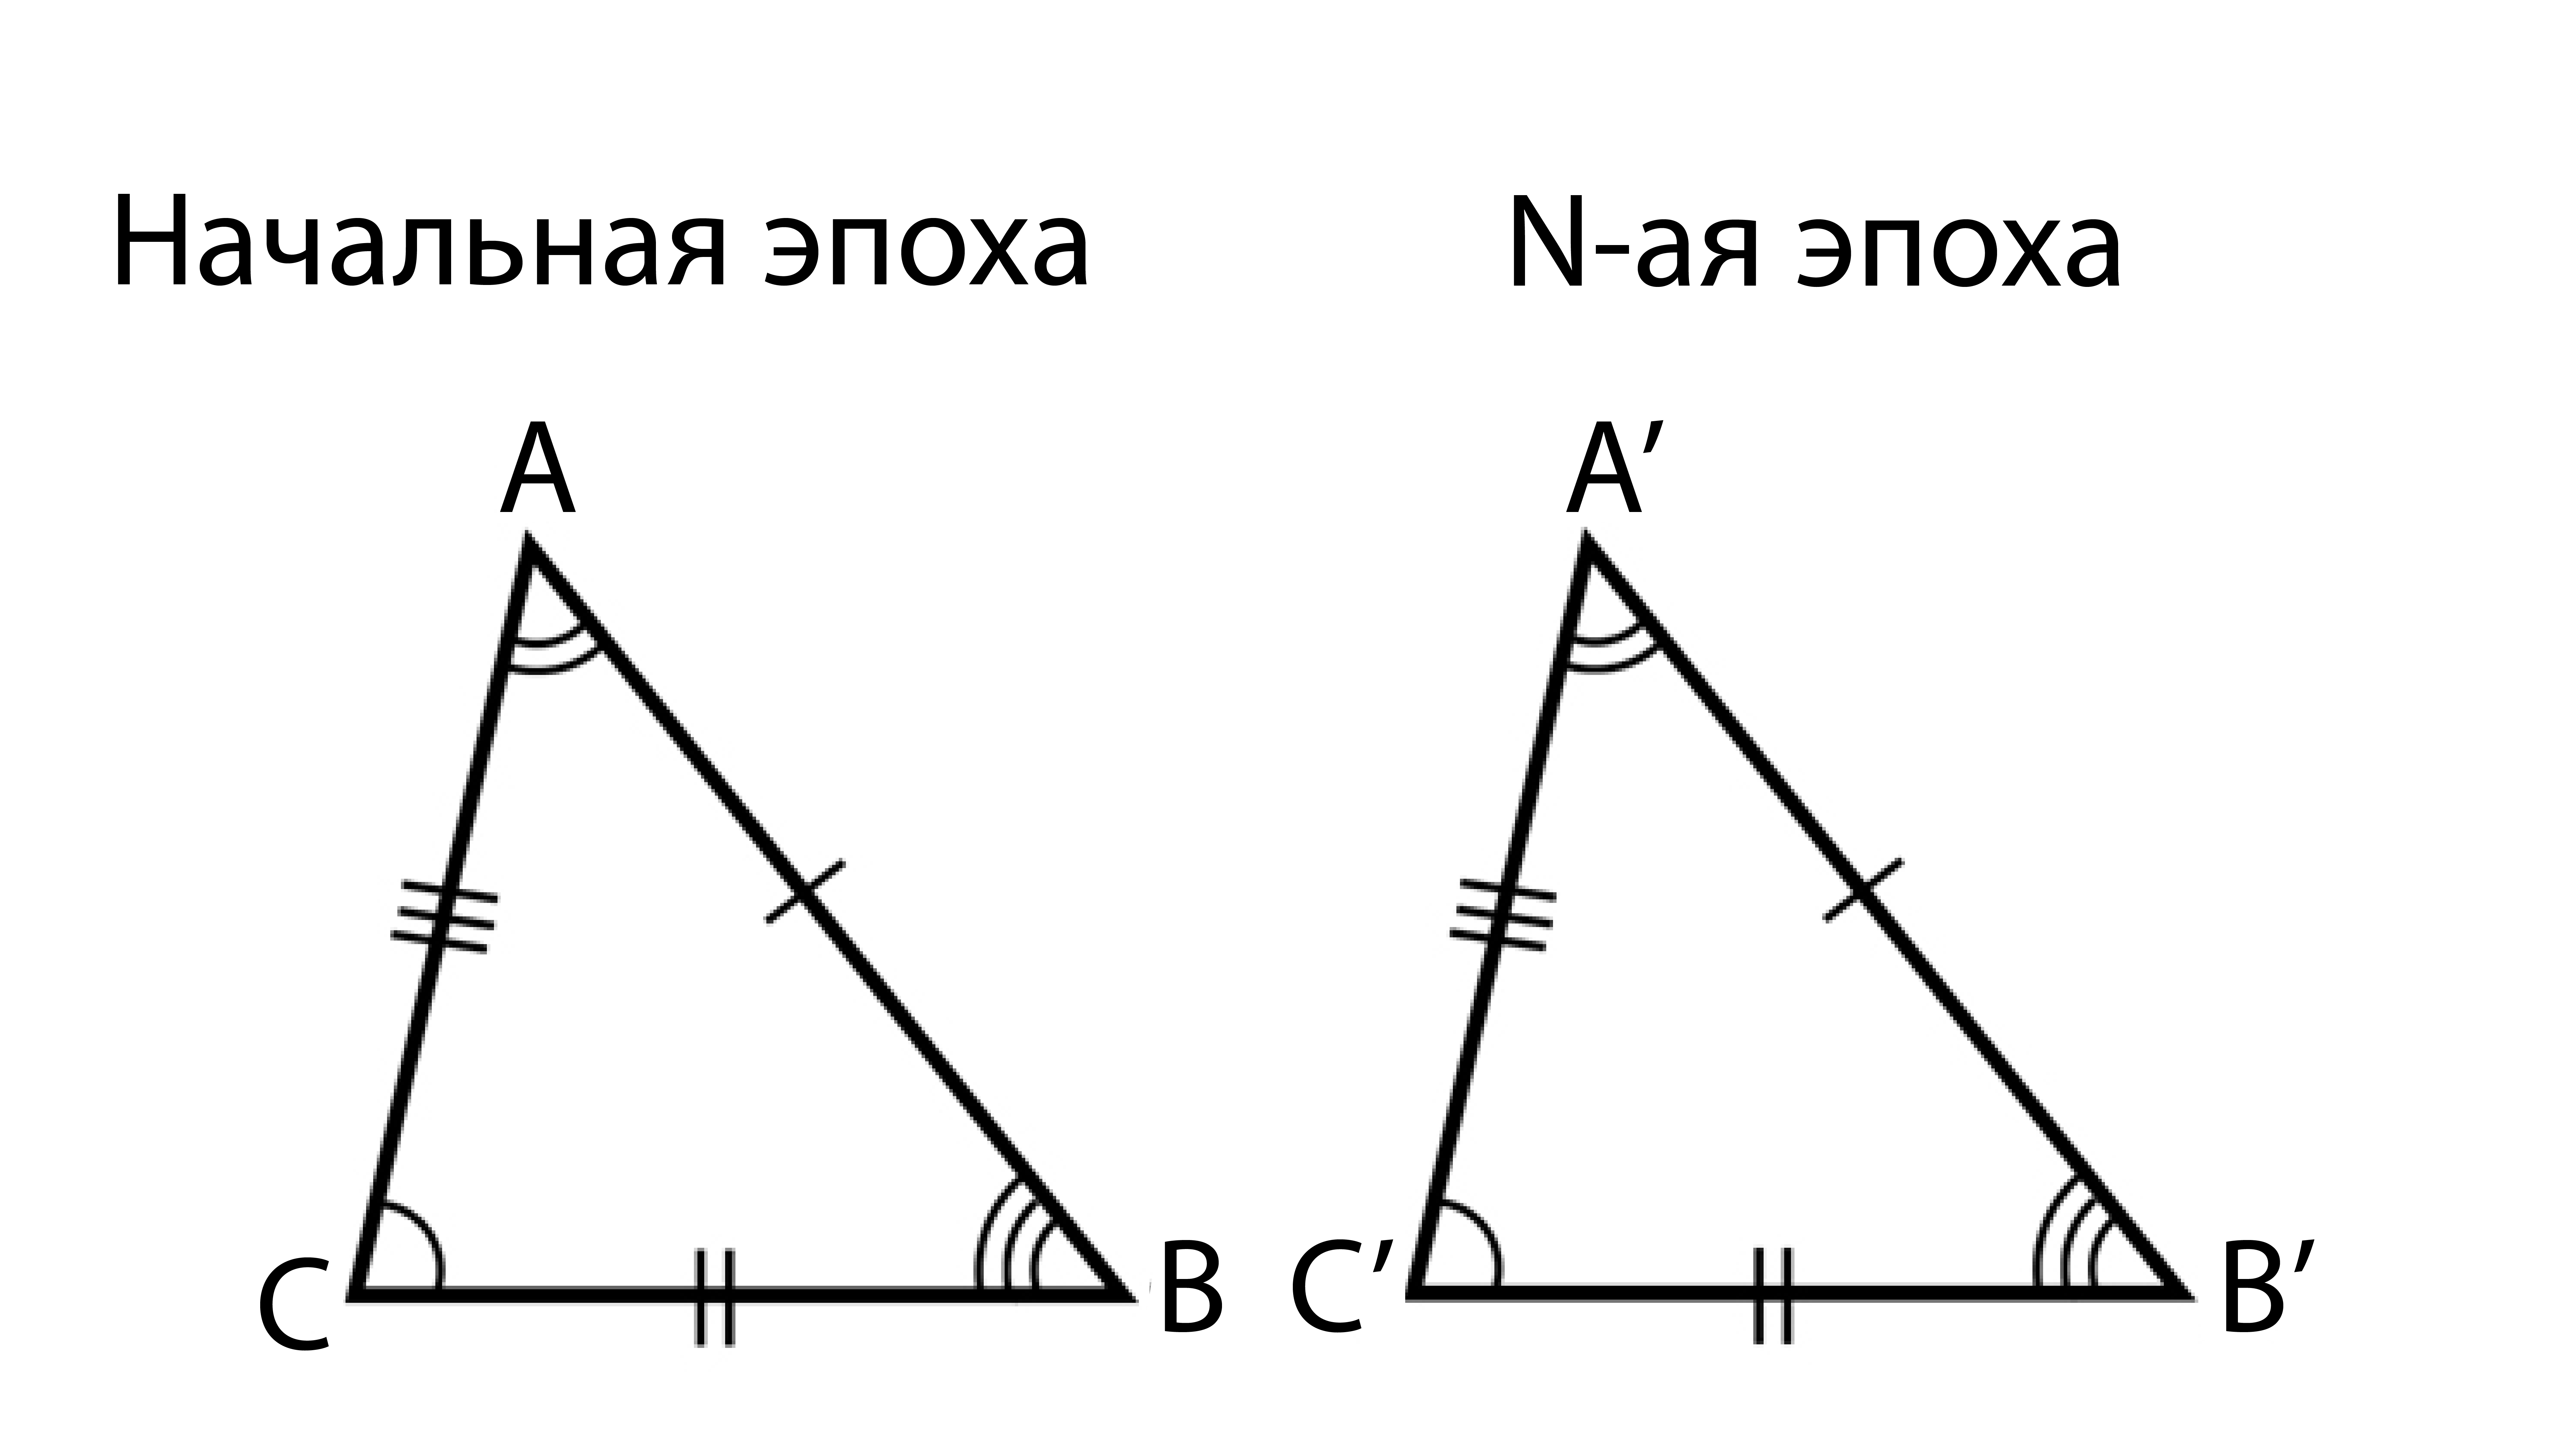

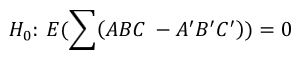

Проверка данной гипотезы выполняется при помощи теста Хи-квадрат, который позволяет оценить статистическую значимость различий между эпохами. Для данной сети может быть вычислено ожидаемое значение статистики. Изменение координат между эпохами считается значимым, если наблюдаемое значение статистики превышает ожидаемое.

Библиотеки, которые нам понадобятся:

In [ ]:
import pandas
import numpy
from scipy.stats import chi2
from scipy.linalg import block_diag

Библиотека **pandas** необходима для обработки и структурирования данных в виде таблиц.
**Numpy** используется для выполнения математических операций с матрицами и другими массивами. **Scipy** содержит модуль **stats**, который позволяет выполнять в Python статистические операции, в частности тест Хи-квадрат, который мы будем использовать. Модуль linalg позволяет составлять блочные диагональные матрицы, он понадобится нам при выполнении линейной регрессии.

Для начала подготовим тестовый временной ряд координат, на котором будем испытывать код программы. Для этого напишем функцию:

In [ ]:
def generate_coordinates(noise, observations, start_coordinate, offset=None):

    # сгенерируем координаты без смещений
    segment = numpy.full(observations*7, start_coordinate)

    # объединяем сегменты в один массив
    Coordinates = numpy.hstack([segment]).astype(float)

    if offset:
        # сгенерируем несколько сегментов временного ряда координаты U со смещением
        segment_1 = numpy.full(observations, start_coordinate + offset)
        segment_2 = numpy.full(observations, start_coordinate + offset*2)
        segment_3 = numpy.full(observations, start_coordinate + offset*3)
        segment_4 = numpy.full(observations, start_coordinate + offset*4)
        segment_5 = numpy.full(observations, start_coordinate + offset*5)
        segment_6 = numpy.full(observations, start_coordinate + offset*6)
        segment_7 = numpy.full(observations, start_coordinate + offset*7)

        # объединяем сегменты в один массив
        Coordinate_U = numpy.hstack([segment_1, segment_2, segment_3,
                                segment_4, segment_5, segment_6,
                                segment_7]).astype(float)

    else:
        # сгенерируем координаты U без смещений
        Coordinate_U = numpy.hstack([segment]).astype(float)

    # добавляем шум в измерения в виде случайного числа с разбросом 0.005
    Coordinates += numpy.random.normal(0, noise, observations*7)
    Coordinate_U += numpy.random.normal(0, noise, observations*7)

    # Добавляем столбцы с СКП
    sigmas = numpy.hstack([numpy.ones(observations*7)*noise])

    # преобразуем в таблицу DataFrame для дальнейшего использования
    df = pandas.DataFrame({0: Coordinates,
                        1: Coordinates + 0.1,
                        2: Coordinate_U + 0.2,
                        3: sigmas, 4: sigmas, 5: sigmas})
    return df

При помощи данной функции сгенерируем 4 временных ряда, чтобы смоделировать геодезическую сеть из 4-х станций.
Первые 3 столбца таблицы содержат координаты E, N, U, следующие 3 столбца - их СКП.

In [ ]:
''' Исходные данные '''
noise = 0.005           # Амплитуда шума в измерениях
offset = 0.05           # Амплитуда смещения координаты
observations = 50       # количество измерений

# Сгенерируем 4 временных ряда, для каждой станции
Station_1 = generate_coordinates(noise=noise, observations=observations,
                           start_coordinate=100, offset=offset)
Station_2 = generate_coordinates(noise=noise, observations=observations,
                           start_coordinate=50)
Station_3 = generate_coordinates(noise=noise, observations=observations,
                           start_coordinate=70)
Station_4 = generate_coordinates(noise=noise, observations=observations,
                           start_coordinate=95)

Так будет выглядеть станция, испытывающая вертикальные деформации:

              0           1           2      3      4      5
0     99.998402  100.098402  100.251724  0.005  0.005  0.005
1     99.998004  100.098004  100.247478  0.005  0.005  0.005
2     99.996458  100.096458  100.257914  0.005  0.005  0.005
3     99.995620  100.095620  100.236751  0.005  0.005  0.005
4     99.996832  100.096832  100.244908  0.005  0.005  0.005
..          ...         ...         ...    ...    ...    ...
345   99.996696  100.096696  100.545693  0.005  0.005  0.005
346  100.008707  100.108707  100.554090  0.005  0.005  0.005
347   99.991742  100.091742  100.555364  0.005  0.005  0.005
348  100.000095  100.100095  100.563396  0.005  0.005  0.005
349   99.996052  100.096052  100.547833  0.005  0.005  0.005

[350 rows x 6 columns]


<Axes: >

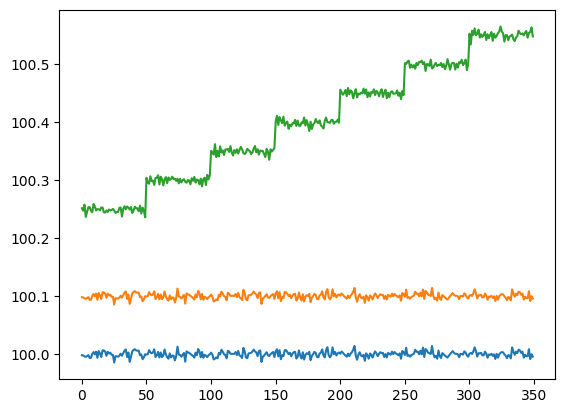

In [ ]:
print(Station_1)
Station_1[0].plot()
Station_1[1].plot()
Station_1[2].plot()

Остальные станции будут неподвижными:

<Axes: >

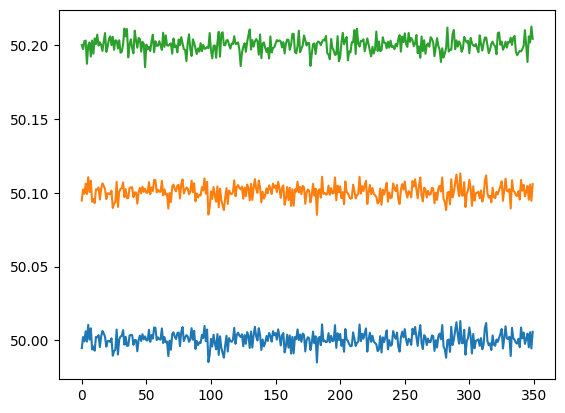

In [ ]:
Station_2[0].plot()
Station_2[1].plot()
Station_2[2].plot()

Главной задачей является определение эпох, а также станций в которых происходит деформация.

Затруднительно напрямую использовать координаты станций, полученные из файлов обработки ГНСС наблюдений. Станции могут записывать измерения с разной частотой, а также в файлах результатах обработки могут отличаться эпохи наблюдений. Поэтому координаты требуется привести к некоторой общей эпохе. Это можно выполнить при помощи линейной регрессии. Она также позволяет уменьшить влияние шума в измерениях. Для этого напишем функцию:

In [ ]:
def linear_regression(time_series_frag, sigma_0):
    """
    Данная функция выполняет линейную регрессию для данного фрагмента временного ряда

    Аргументы:
        time_series_frag (DataFrame): Фрагмент временного ряда
        sigma_0 (float): Значение СКП

    Возвращает:
        tuple: Кортеж с координатами, вычисленными с помощью линейной регрессии
    """
    # переделка массива с координатами в общий вектор свободных членов
    L = numpy.zeros((time_series_frag.shape[0]*3))
    Q = numpy.zeros((time_series_frag.shape[0]*3,time_series_frag.shape[0]*3))
    for i in range (time_series_frag.shape[0]) :
        L[3*i] = time_series_frag.iloc[i][0]
        L[3*i+1] = time_series_frag.iloc[i][1]
        L[3*i+2] = time_series_frag.iloc[i][2]
        Q[3*i,3*i] = time_series_frag.iloc[i][3]**2
        Q[3*i+1,3*i+1] = time_series_frag.iloc[i][4]**2
        Q[3*i+2,3*i+2] = time_series_frag.iloc[i][5]**2

    # задаем массив эпох
    t = numpy.arange(0, time_series_frag.shape[0], 1)

    # цикл формирования матрицы коэффициентов
    for m in range (time_series_frag.shape[0]):
        ti = t[m]
        if m == 0 : A=numpy.hstack((numpy.identity(3)*ti, numpy.identity(3)))
        else:
            Aux=numpy.hstack((numpy.identity(3)*ti, numpy.identity(3)))
            A=numpy.vstack((A, Aux))

    #формирование матрицы весов
    P = Q / sigma_0 ** 2

    # решаем СЛАУ
    N = A.transpose().dot(numpy.linalg.inv(P)).dot(A)
    # вектор параметров кинематической модели
    X = numpy.linalg.inv(N).dot(A.transpose().dot(numpy.linalg.inv(P)).dot(L))
    x_LS = numpy.array([X[0]*t[-1]+X[3], X[1]*t[-1]+X[4], X[2]*t[-1]+X[5]])

    #вычисляем вектор невязок
    V = A.dot(X) - L

    # СКП единицы веса
    mu = numpy.sqrt((V.transpose().dot(numpy.linalg.inv(P)).dot(V))/(V.shape[0]-6))

    Qx = numpy.linalg.inv(N)
    С = numpy.array([[t[-1],0,0,1,0,0],[0,t[-1],0,0,1,0],[0,0,t[-1],0,0,1]])

    Qv = С.dot(Qx).dot(С.transpose())

    return (x_LS,Qv,mu, Qx,V)

Для выполнения линейной регрессии необходимо разделить временной ряд на равные отрезки, так называемые "окна". На конец каждого окна в результате линейной регрессии будут получены усредненные координаты. Далее можно попробовать определить моменты деформаций. Для этого мы вычисляем вектор скорости каждой станции на каждую эпоху (в коде обозначен как d). После чего мы используем тест Хи-квадрат для определения, насколько ожидаемые значения (test_value) этого вектора совпадают с наблюдаемыми (test_statistic). Для этого напишем функцию:

In [ ]:
def geometric_test_statictics(time_series_df, window, sigma_0):
    """
    Функция разделяет временной ряд на окна, затем выполняет линейную регрессию
    и рассчет статистики геометрического теста.

    Аргументы:
        time_series_df (DataFrame): Временной ряд координат
        window (int): Размер окна (в данном случае кол-во эпох)
        sigma_0 (float): Значение СКП

    Возвращает:
        tuple: Кортеж с координатами, вычисленными с помощью линейной регрессии,
               а также результаты геометрического теста
    """
    # Создаем необходимые списки для хранения данных
    epochs = int(time_series_df[0].shape[0] / window)
    num_dfs = len(time_series_df)
    X_WLS = numpy.ndarray(shape=(epochs,1,3*num_dfs))
    Qv_WLS = numpy.ndarray(shape=(epochs,3*num_dfs,3*num_dfs))
    mu_WLS = numpy.zeros(epochs)

    # Цикл для разделения временного ряда на окна
    end = 0
    for j in range (epochs) :
        st = end
        end = int((j + 1) * window)

        mu_sum = 0
        x_LS_list = []
        Qv_list = []

        for df in time_series_df:
            x_LS, Qv, mu, Qx, V = linear_regression(df.iloc[st:end], 0.005)
            x_LS_list.append(x_LS)
            Qv_list.append(Qv)
            mu_sum += mu ** 2

        mu_WLS[j] = mu_sum
        X_WLS[j] = numpy.hstack(x_LS_list)
        Qv_WLS[j] = block_diag(*Qv_list)


    # список для хранения значений статистики
    test_statistic = numpy.zeros((epochs-1))

    # список для хранения эпох с отвергнутой гипотезой
    rejected_epochs = []

    # Расчет статистики при помощи теста Хи-квадрат
    for l in range(epochs-1):
        Qdd = Qv_WLS[l] + Qv_WLS[l+1]
        d = X_WLS[l]-X_WLS[l+1]
        sigma_0 = mu_WLS[l] + mu_WLS[l+1]
        test_statistic[l] = d.dot(numpy.linalg.inv(Qdd)).dot(d.transpose())/sigma_0
        test_value = chi2.ppf(df=((d.shape[0])/3)*6, q=0.95)
        if test_statistic[l] > test_value :
            print('reject, l =',l*window)
            print('test_value =',test_value)
            print('test_statistic =',test_statistic[l])
            rejected_epochs.append(l*window)

    return X_WLS, Qv_WLS, test_statistic, rejected_epochs

Далее выполним геометрический тест на сгенерированной сети пунктов. Окно для линейной регрессии будет равно 5 эпохам:

In [ ]:
window = 5
dfs = [Station_1, Station_2, Station_3, Station_4]
X_WLS, Qv_WLS, test_statistic, rejected_epochs = geometric_test_statictics(time_series_df=dfs, window=window, sigma_0=0.05)

reject, l = 45
test_value = 5.991464547107979
test_statistic = 18.62695243217785
reject, l = 95
test_value = 5.991464547107979
test_statistic = 9.549092626013438
reject, l = 145
test_value = 5.991464547107979
test_statistic = 10.054490373513762
reject, l = 195
test_value = 5.991464547107979
test_statistic = 12.758304701357968
reject, l = 245
test_value = 5.991464547107979
test_statistic = 13.59977740107395
reject, l = 295
test_value = 5.991464547107979
test_statistic = 14.810926237031795


<ipython-input-262-6e7dae83b883>:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_statistic[l] = d.dot(numpy.linalg.inv(Qdd)).dot(d.transpose())/sigma_0


Визуализируем результаты на графике при помощи библиотеки **matplotlib**.

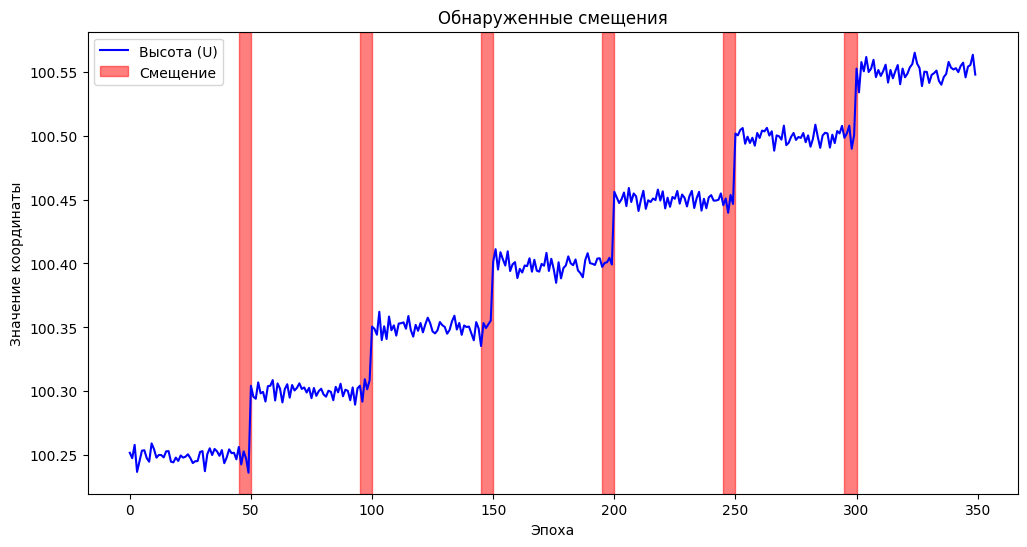

In [ ]:
import matplotlib.pyplot as plt

# создаем график
plt.figure(figsize=(12, 6))

# отображаем колонку со значениями высоты
plt.plot(Station_1[2], label='Высота (U)', color='blue')

# подсвечиваем эпохи, которые содержат деформации
for epoch in rejected_epochs:
    plt.axvspan(epoch, epoch + window, color='red', alpha=0.5, label=f'Смещение' if epoch == rejected_epochs[0] else "")

plt.title('Обнаруженные смещения')
plt.xlabel('Эпоха')
plt.ylabel('Значение координаты')
plt.legend()

# Показать график
plt.show()

Нам удалось определить все эпохи, в которых происходили деформации сети. Однако неизвестно, какая из четырех станций испытывает деформации. Напишем функцию find_offset_points(), которая последовательно исключает из сети каждую станцию и заново выполняет геометрический тест до тех пор, пока деформация не исчезнет. Таким образом деформированная станция (или несколько станций) будет найдена:

In [ ]:
import itertools

def find_offset_points(dfs):
    """
    Функция выполняет перебор станций и выполняет геометрический тест,
    последовательно исключая каждую из них

    Аргументы:
        dfs (list): Словарь с названиями станций, ассоциированными с их измерениями

    Возвращает:
        list: Список станций, которые определены как содержащие деформации
    """
    # список для станций с деформацией
    excluded_stations = []

    for station_name, df in dfs_dict.items():
        # Создаем новый список, из которого исключена одна из станций
        non_station_dfs = [d for name, d in dfs_dict.items() if name != station_name]

        # Выполняем геометрический тест
        X_WLS, Qv_WLS, test_statistic, rejected_epochs = geometric_test_statictics(
            time_series_df=non_station_dfs, window=window, sigma_0=0.05)

        # Если деформаций не выявлено, добавляем эту станцию в список
        if not rejected_epochs:
            excluded_stations.append(station_name)
            break

    return excluded_stations

Применяем эту функцию:

In [ ]:
dfs_dict = {'Station 1': Station_1,
            'Station 2': Station_2,
            'Station 3': Station_3,
            'Station 4': Station_4}

offset_points = find_offset_points(dfs_dict)

<ipython-input-262-6e7dae83b883>:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_statistic[l] = d.dot(numpy.linalg.inv(Qdd)).dot(d.transpose())/sigma_0


In [ ]:
offset_points

['Station 1']

Функция верно определила название станции, которую мы смоделировали как испытывающую вертикальные деформации.